# Load Libraries and Read in Data

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

warnings.simplefilter('ignore', FutureWarning)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

In [2]:
## Read in the cleaned dataframe from Lab 1
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)

# Split data into Test/Train

In [3]:
# Summary statistics of each feature
runs_df.info()
runs_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79423 entries, 0 to 79422
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       79423 non-null  int64  
 1   race_id          79423 non-null  int64  
 2   horse_no         79423 non-null  int64  
 3   horse_id         79423 non-null  int64  
 4   result           79423 non-null  int64  
 5   won              79423 non-null  float64
 6   lengths_behind   79423 non-null  float64
 7   horse_age        79423 non-null  int64  
 8   horse_country    79423 non-null  object 
 9   horse_type       79423 non-null  object 
 10  horse_rating     79423 non-null  int64  
 11  horse_gear       79423 non-null  object 
 12  declared_weight  79423 non-null  float64
 13  actual_weight    79423 non-null  int64  
 14  draw             79423 non-null  int64  
 15  position_sec1    79423 non-null  int64  
 16  position_sec2    79423 non-null  int64  
 17  position_sec

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


In [4]:
# Split the data and target
# Only use features known pre-race (e.g. not finish time)
# Remove non-numerical features (e.g. horse country)
runs_data = runs_df.drop(['Unnamed: 0','race_id','result','won','lengths_behind',
                          #'horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id'
                          'position_sec1','position_sec2',
                          'position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2',
                          'time3','finish_time'], axis=1)
runs_target = runs_df['won']

X_train,X_test,Y_train,Y_test = train_test_split(runs_data,runs_target,test_size=0.20,random_state=0)# Add a Place result feature


In [5]:
# Add a Place result feature
# Add Race vars if wanted
# Add any created vars if wanted
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63538 entries, 62425 to 68268
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   horse_no         63538 non-null  int64  
 1   horse_id         63538 non-null  int64  
 2   horse_age        63538 non-null  int64  
 3   horse_country    63538 non-null  object 
 4   horse_type       63538 non-null  object 
 5   horse_rating     63538 non-null  int64  
 6   horse_gear       63538 non-null  object 
 7   declared_weight  63538 non-null  float64
 8   actual_weight    63538 non-null  int64  
 9   draw             63538 non-null  int64  
 10  win_odds         63538 non-null  float64
 11  place_odds       63538 non-null  float64
 12  trainer_id       63538 non-null  int64  
 13  jockey_id        63538 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 7.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15885 entries, 4284 to 16318
Data colum

# Creating an SVM

Creating a Support Vector Machine (SVM) requires the data to be pre-processed into the appropriate format before the model can be trained. SVMs can handle both numerical and categorical predictors to classify a response. We are using this SVM to predict the won variable which describes whether the horse wone the race. To ensure the range of a predictors does not contribute to the influence of the variable over the response, we will scale the data first. Next, the data needs to be one-hot encoded. Attributes with many categories can cause the model training to be greatly slowed, so we will limit the categorical levels before encoding. With the data frame in the proper format, we need to balance the dataset to ensure the minority class is not ignored. We used downsampling of the losing horse class to balance the number of winning and losing horses. Finally, we will tune our model parameters and predict our test set. We used an 80/20 test/train split.

# Scale The Data

In [6]:
## Normalize the scales of variables (no need to scale y as that is the prediction)

#Remove categorical vars
cat_x_train = X_train[['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id']].astype(object)
cat_x_test = X_test[['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id']].astype(object)
num_x_train = X_train.drop(['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id'],axis=1)
num_x_test = X_test.drop(['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id'],axis=1)

#Very important to fit the scale to only the training data set... 
#and apply the transfromation to the test data set
scl_obj = StandardScaler()
scl_x_train = scl_obj.fit_transform(num_x_train)
scl_x_test = scl_obj.transform(num_x_test)

scl_x_train=pd.DataFrame(scl_x_train, columns=num_x_train.columns)
scl_x_test=pd.DataFrame(scl_x_test, columns=num_x_test.columns)

#Add categorical variables back in
scl_x_train.index = cat_x_train.index
scl_x_test.index = cat_x_test.index
scl_x_train = pd.concat([scl_x_train, cat_x_train],axis=1)
scl_x_test = pd.concat([scl_x_test, cat_x_test],axis=1)

scl_x_train.describe()

,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds
count,6.353800e+04,6.353800e+04,6.353800e+04,6.353800e+04,6.353800e+04,6.353800e+04,6.353800e+04,6.353800e+04
mean,-2.725846e-18,6.377431e-17,2.029043e-16,-1.087930e-15,7.200289e-16,1.481742e-17,1.276115e-16,1.287298e-16
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-1.568999e+00,-1.527638e+00,-4.343842e+00,-6.608647e+00,-3.133311e+00,-1.567262e+00,-9.238534e-01,-7.433377e-01
25%,-7.707318e-01,-3.863104e-01,-8.556892e-02,-6.881142e-01,-7.514050e-01,-7.662460e-01,-7.011894e-01,-5.815941e-01
50%,2.753526e-02,-3.863104e-01,-8.556892e-02,-4.632208e-02,4.256376e-02,3.476977e-02,-4.585852e-01,-3.505319e-01
75%,8.258024e-01,-3.863104e-01,-8.556892e-02,6.596493e-01,8.365325e-01,8.357855e-01,3.057839e-01,8.848643e-02
max,1.890159e+00,7.602982e+00,6.557338e+00,4.237641e+00,1.630501e+00,1.903806e+00,2.333024e+00,1.080978e+01


The scaling method used takes the numerical variables of the training data and scales based on a normal distribution of mean 0 and standard deviation 1. We can see all the variables after scaling above and they follow the expected mean and standard deviation. The categorical variables are concatenated back to the dataframe after scaling.

# Limit Categories

In [7]:
cat_lim_train=scl_x_train.copy()
cat_lim_test=scl_x_test.copy()

#Update Horse ID to horses who have raced over 60 times
horse_id_counts = cat_lim_train.horse_id.value_counts()
cat_lim_train.loc[~cat_lim_train.horse_id.isin(horse_id_counts.index[horse_id_counts.gt(60)]),'horse_id']='Other'
cat_lim_test.loc[~cat_lim_test.horse_id.isin(horse_id_counts.index[horse_id_counts.gt(60)]),'horse_id']='Other'
print('Horse ID')
print('original: ',len(scl_x_train.horse_id.unique()))
print('new: ',len(cat_lim_train.horse_id.unique()))
print(cat_lim_train.horse_id.unique(),"\n")

#Update Horse Country to countries that appear over 80 times
horse_country_counts = cat_lim_train.horse_country.value_counts()
cat_lim_train.loc[~cat_lim_train.horse_country.
                  isin(horse_country_counts.index[horse_country_counts.gt(80)]),'horse_country']='Other'
cat_lim_test.loc[~cat_lim_test.horse_country.
                 isin(horse_country_counts.index[horse_country_counts.gt(80)]),'horse_country']='Other'
print('Horse Country')
print('original: ',len(scl_x_train.horse_country.unique()))
print('new: ',len(cat_lim_train.horse_country.unique()))
print(cat_lim_train.horse_country.unique(),"\n")

#Update Horse Type to types that appear over 50 times
horse_type_counts = cat_lim_train.horse_type.value_counts()
cat_lim_train.loc[~cat_lim_train.horse_type.isin(horse_type_counts.index[horse_type_counts.gt(50)]),
                  'horse_type']='Other'
cat_lim_test.loc[~cat_lim_test.horse_type.isin(horse_type_counts.index[horse_type_counts.gt(50)]),
                 'horse_type']='Other'
print('Horse Type')
print('original: ',len(scl_x_train.horse_type.unique()))
print('new: ',len(cat_lim_train.horse_type.unique()))
print(cat_lim_train.horse_type.unique(),"\n")

#Update Horse Gear to gear combos that appear over 300 times
horse_gear_counts = cat_lim_train.horse_gear.value_counts()
cat_lim_train.loc[~cat_lim_train.horse_gear.isin(horse_gear_counts.index[horse_gear_counts.gt(300)]),
                  'horse_gear']='Other'
cat_lim_test.loc[~cat_lim_test.horse_gear.isin(horse_gear_counts.index[horse_gear_counts.gt(300)]),
                 'horse_gear']='Other'
print('Horse Gear')
print('original: ',len(scl_x_train.horse_gear.unique()))
print('new: ',len(cat_lim_train.horse_gear.unique()))
print(cat_lim_train.horse_gear.unique(),"\n")

#Update TrainerID to trainers that appear over 2500 times
trainer_id_counts = cat_lim_train.trainer_id.value_counts()
cat_lim_train.loc[~cat_lim_train.trainer_id.isin(trainer_id_counts.index[trainer_id_counts.gt(2500)]),
                  'trainer_id']='Other'
cat_lim_test.loc[~cat_lim_test.trainer_id.isin(trainer_id_counts.index[trainer_id_counts.gt(2500)]),
                 'trainer_id']='Other'
print('Trainer ID')
print('original: ',len(scl_x_train.trainer_id.unique()))
print('new: ',len(cat_lim_train.trainer_id.unique()))
print(cat_lim_train.trainer_id.unique(),"\n")

#Update JockeyID to jockeys that appear over 2000 times
jockey_id_counts = cat_lim_train.jockey_id.value_counts()
cat_lim_train.loc[~cat_lim_train.jockey_id.isin(jockey_id_counts.index[jockey_id_counts.gt(2000)]),
                  'jockey_id']='Other'
cat_lim_test.loc[~cat_lim_test.jockey_id.isin(jockey_id_counts.index[jockey_id_counts.gt(2000)]),
                 'jockey_id']='Other'
print('Jockey ID')
print('original: ',len(scl_x_train.jockey_id.unique()))
print('new: ',len(cat_lim_train.jockey_id.unique()))
print(cat_lim_train.jockey_id.unique())

Horse ID
original:  4308
new:  12
['Other' 107 2382 1849 4314 3887 779 4058 4041 493 3323 70] 

Horse Country
original:  16
new:  10
['NZ' 'USA' 'AUS' 'GB' 'IRE' 'FR' 'SAF' 'GER' 'Other' 'ARG'] 

Horse Type
original:  9
new:  7
['Gelding' 'Brown' 'Other' 'Colt' 'Horse' 'Mare' 'Rig'] 

Horse Gear
original:  735
new:  10
['--' 'TT/B' 'Other' 'B' 'CP' 'TT/H' 'H' 'TT' 'XB' 'SR'] 

Trainer ID
original:  155
new:  13
[97 118 7 80 69 'Other' 137 98 75 47 55 164 138] 

Jockey ID
original:  178
new:  13
[76 175 'Other' 162 50 40 34 63 2 138 64 18 149]


Many of the categorical variables in the dataset have hundreds or thousands of categories. To simplify the classes, we will use a mimimum instance limit for each categorical variable to determine which classes to keep (instance limit in code notes above each section). Any class not meeting the instance limit, will be classified as 'Other'. This generalization of the smaller classes will be done useing the training data set and then the results will be applied to the test data set. In the above output, each categorical variable is shown with the original number of categories and the new number of categories after generalization. A list of the new unique categories is listed at the end of each section.

# One Hot Encode the Data

In [8]:
#Create Dummies for training and test
dummies_train = pd.get_dummies(
    cat_lim_train[['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id']])
dummies_test = pd.get_dummies(
    cat_lim_test[['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id']])

#Add dummies back to original data frames
final_train = pd.concat([cat_lim_train, dummies_train],axis=1)
final_test = pd.concat([cat_lim_test, dummies_test],axis=1)

#Drop original variable and one class for each variable (the dropped class is 'Other')
final_train = final_train.drop(['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id',
                            'horse_id_Other','horse_country_Other','horse_type_Other','horse_gear_Other',
                            'trainer_id_Other','jockey_id_Other'], axis=1)
final_test = final_test.drop(['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id',
                            'horse_id_Other','horse_country_Other','horse_type_Other','horse_gear_Other',
                            'trainer_id_Other','jockey_id_Other'], axis=1)

print('Original Training Set Shape Before Dummies:\n',cat_lim_train.shape)
print('Original Test Set Shape Before Dummies:\n',cat_lim_test.shape)
print('New Training Set Shape After Dummies:\n',final_train.shape)
print('New Test Set Shape After Dummies:\n',final_test.shape)

Original Training Set Shape Before Dummies:
 (63538, 14)
Original Test Set Shape Before Dummies:
 (15885, 14)
New Training Set Shape After Dummies:
 (63538, 67)
New Test Set Shape After Dummies:
 (15885, 67)


For the SVM to be able to interpret categorical data, it must be one-hot encoded. This means that each class in each categorical variable will become a column. By limiting the caltegorical variable classes above, we ensured the data frame will not overly expand. After creating the dummy variables and adding them to our existing test and training sets, we must drop the original categorical variables and one class from each categorical variable. The 'Other' class was dropped from each categorical variable. The above output shows the shape of the training and test sets before and after performing the one-hot encoding process. The data sets do not change the number of instances but they expanded from 14 to 67 columns.

# Balance the data

In [9]:
print('train responses before:\n',Y_train.value_counts())

losses=Y_train.loc[Y_train==0]
wins=Y_train.loc[Y_train==1]
sample_losses=losses.sample(5101,random_state=0)
balanced_final_train = final_train[final_train.index.isin(sample_losses.index | wins.index)]
balanced_Y_train = Y_train[Y_train.index.isin(sample_losses.index | wins.index)]

print('train responses after balancing:\n',balanced_Y_train.value_counts())

train responses before:
 0.0    58437
1.0     5101
Name: won, dtype: int64
train responses after balancing:
 0.0    5101
1.0    5101
Name: won, dtype: int64


Training a classification model with a highly imbalanced dataset can run the risk of the model overpredicting the minority class. There are many possible approaches to resolve this, and we decided to downsample the majority class which is horses that lost the race. We took a random sample from the horses that lost in the training data set to match the number of instances of horses that won. This made the class distribution 50/50. There is no need to do this to the test dataset because we are only trying to change the way the model is trained.

# Create SVM

### Create SVM with all Variables

In [10]:
balanced_final_train.info()
Y_test.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10202 entries, 62425 to 42613
Data columns (total 67 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   horse_no            10202 non-null  float64
 1   horse_age           10202 non-null  float64
 2   horse_rating        10202 non-null  float64
 3   declared_weight     10202 non-null  float64
 4   actual_weight       10202 non-null  float64
 5   draw                10202 non-null  float64
 6   win_odds            10202 non-null  float64
 7   place_odds          10202 non-null  float64
 8   horse_id_70         10202 non-null  uint8  
 9   horse_id_107        10202 non-null  uint8  
 10  horse_id_493        10202 non-null  uint8  
 11  horse_id_779        10202 non-null  uint8  
 12  horse_id_1849       10202 non-null  uint8  
 13  horse_id_2382       10202 non-null  uint8  
 14  horse_id_3323       10202 non-null  uint8  
 15  horse_id_3887       10202 non-null  uint8  
 16  

0.0    14626
1.0     1259
Name: won, dtype: int64

### Find optimal C

accuracy: 0.5159584513692163
auc: 0.6874213579633992


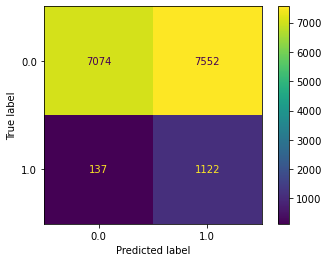

In [11]:
# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto',random_state=0) # get object
svm_clf.fit(balanced_final_train, balanced_Y_train)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
auc=roc_auc_score(Y_test,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

accuracy: 0.534466477809254
auc: 0.6909387647553775


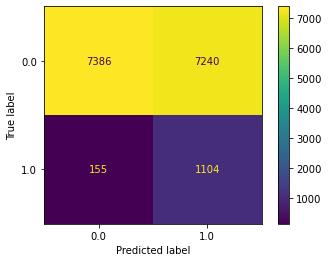

In [12]:
# train the model just as before
svm_clf = SVC(C=1, kernel='rbf', degree=3, gamma='auto',random_state=0) # get object
svm_clf.fit(balanced_final_train, balanced_Y_train)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
auc=roc_auc_score(Y_test,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

accuracy: 0.5836323575700346
precision: 0.1393939393939394
recall: 0.8220810166799047
auc: 0.6925939063982048


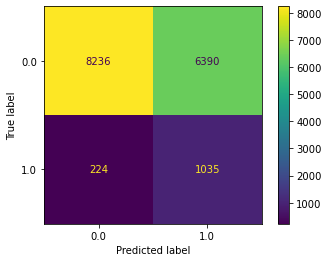

In [13]:
# train the model just as before
svm_clf = SVC(C=10, kernel='rbf', degree=3, gamma='auto',random_state=0) # get object
svm_clf.fit(balanced_final_train, balanced_Y_train)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_test,y_hat)
precision = mt.precision_score(Y_test,y_hat)
recall = mt.recall_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
auc=roc_auc_score(Y_test,y_hat)
print('accuracy:', acc )
print('precision:', precision )
print('recall:', recall )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

accuracy: 0.5891092225369846
auc: 0.6912126033187334


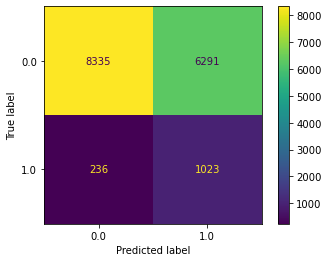

In [14]:
# train the model just as before
svm_clf = SVC(C=15, kernel='rbf', degree=3, gamma='auto',random_state=0) # get object
svm_clf.fit(balanced_final_train, balanced_Y_train)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
auc=roc_auc_score(Y_test,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

accuracy: 0.593075228202707
auc: 0.692277437537926


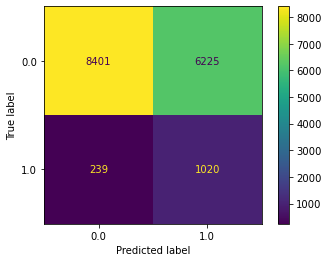

In [15]:
# train the model just as before
svm_clf = SVC(C=20, kernel='rbf', degree=3, gamma='auto',random_state=0) # get object
svm_clf.fit(balanced_final_train, balanced_Y_train)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
auc=roc_auc_score(Y_test,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

accuracy: 0.6098835379288637
auc: 0.69051637182612


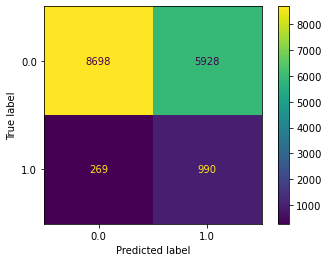

In [16]:
# train the model just as before
svm_clf = SVC(C=50, kernel='rbf', degree=3, gamma='auto',random_state=0) # get object
svm_clf.fit(balanced_final_train, balanced_Y_train)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
auc=roc_auc_score(Y_test,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

accuracy: 0.6188857412653447
auc: 0.688871738415719


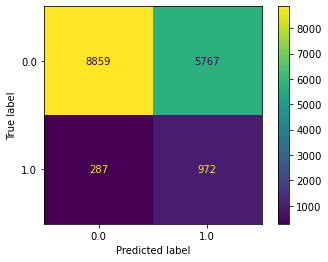

In [17]:
# train the model just as before
svm_clf = SVC(C=100, kernel='rbf', degree=3, gamma='auto',random_state=0) # get object
svm_clf.fit(balanced_final_train, balanced_Y_train)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
auc=roc_auc_score(Y_test,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

accuracy: 0.6293358514321687
auc: 0.6713174510405975


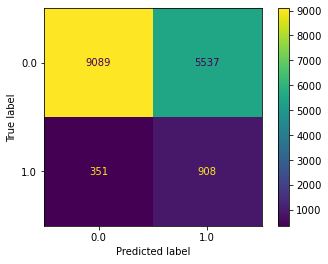

In [18]:
# train the model just as before
svm_clf = SVC(C=1000, kernel='rbf', degree=3, gamma='auto',random_state=0) # get object
svm_clf.fit(balanced_final_train, balanced_Y_train)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
auc=roc_auc_score(Y_test,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

### Find Optimal Gamma

accuracy: 0.6636449480642115
auc: 0.6180835873139621


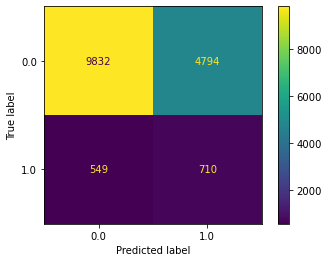

In [19]:
# train the model just as before
svm_clf = SVC(C=10, kernel='rbf', degree=3, gamma=1,random_state=0) # get object
svm_clf.fit(balanced_final_train, balanced_Y_train)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
auc=roc_auc_score(Y_test,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

accuracy: 0.6332389046270066
auc: 0.6371414751299191


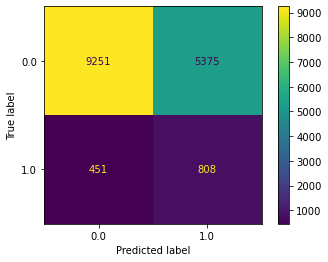

In [20]:
# train the model just as before
svm_clf = SVC(C=10, kernel='rbf', degree=3, gamma=.5,random_state=0) # get object
svm_clf.fit(balanced_final_train, balanced_Y_train)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
auc=roc_auc_score(Y_test,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

accuracy: 0.631853950267548
auc: 0.6701441946713322


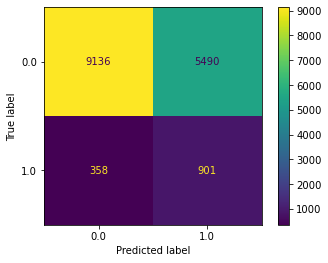

In [21]:
# train the model just as before
svm_clf = SVC(C=10, kernel='rbf', degree=3, gamma=.1,random_state=0) # get object
svm_clf.fit(balanced_final_train, balanced_Y_train)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
auc=roc_auc_score(Y_test,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

## Selected Model

accuracy: 0.5836323575700346
precision: 0.1393939393939394
recall: 0.8220810166799047
auc: 0.6925939063982048


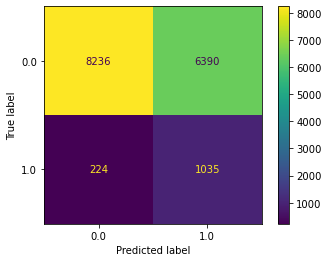

In [22]:
# train the model just as before
svm_clf = SVC(C=10, kernel='rbf', degree=3, gamma='auto',random_state=0) # get object
svm_clf.fit(balanced_final_train, balanced_Y_train)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_test,y_hat)
precision = mt.precision_score(Y_test,y_hat)
recall = mt.recall_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
auc=roc_auc_score(Y_test,y_hat)
print('accuracy:', acc )
print('precision:', precision )
print('recall:', recall )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

accuracy: 0.5281082782499213
precision: 0.1393939393939394
recall: 0.8220810166799047
auc: 0.6874860093882231
Support Vector Details:
w =  [[-3.20151149e-02 -5.45305885e-03 -2.58696975e-02  6.27355311e-03
  -4.01712159e-02  1.26049745e-02 -2.13773544e+00 -9.50140009e-02
   4.53960965e-01 -6.74717374e-01  3.29146039e-01 -1.19463643e+00
   0.00000000e+00  6.87427125e-01 -2.11718631e-01  5.16633192e-01
   1.00893315e-01 -5.72927430e-02  3.70880108e-02  1.45305695e-01
  -1.10641680e-02  5.17722280e-02  2.34643947e-02 -1.12241019e+00
   5.52672951e-03  2.29390589e-02  2.97672811e-01  6.63672976e-02
   9.72126372e-01  7.95380811e-01  8.36914442e-01  9.67260190e-01
   7.80076058e-01  9.69485026e-01 -5.87058190e-02 -5.49986225e-02
  -9.10732085e-02  5.81094982e-02  1.80160971e-01  2.44105061e-02
   4.85253532e-03  2.32589998e-02 -1.51164773e-01  5.14062422e-02
  -8.05501844e-02 -2.92284824e-02  1.67368042e-02  5.76439181e-02
   1.82875700e-02  4.27910300e-02 -6.01112686e-01  3.13473270e-02
   

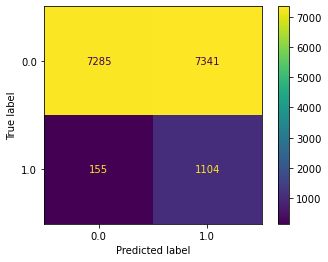

In [23]:
#Code referenced from https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights
# train the model just as before
svm_clf = SVC(C=10, kernel='linear', degree=3,random_state=0) # get object
svm_clf.fit(balanced_final_train, balanced_Y_train)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
auc=roc_auc_score(Y_test,y_hat)
print('accuracy:', acc )
print('precision:', precision )
print('recall:', recall )
print('auc:',auc)
print('Support Vector Details:')
print('w = ',svm_clf.coef_)
print('b = ',svm_clf.intercept_)
print('Indices of support vectors = ', svm_clf.support_)
print('Support vectors = ', svm_clf.support_vectors_)
print('Number of support vectors for each class = ', svm_clf.n_support_)
print('Coefficients of the support vector in the decision function = ', np.abs(svm_clf.dual_coef_))
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

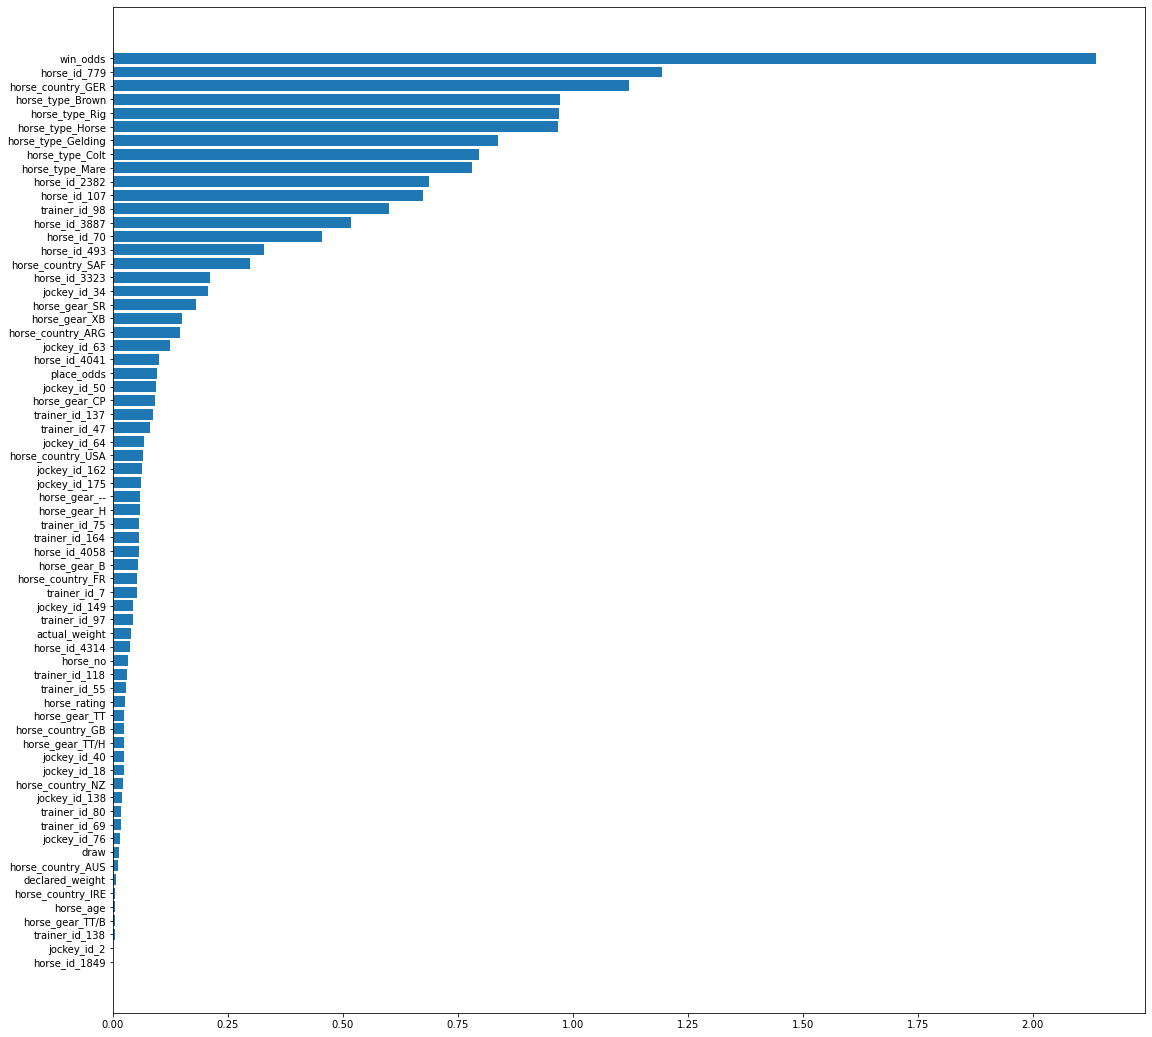

In [24]:
#Function referenced from https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
def f_importances(coef, names):
    imp = np.absolute(coef)
    imp,names = zip(*sorted(zip(imp,names)))
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 18.5, forward=True)
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features=balanced_final_train.columns.to_list
f_importances(svm_clf.coef_[0], balanced_final_train.columns)

In [25]:
#Parameter grid code was referenced from https://www.youtube.com/watch?v=8A7L0GsBiLQ
# param_grid = [
#     {'C':[1,10,100,1000],
#     'gamma':['scale',1,.1,.01],
#     'kernel':['rbf']}
# ]

# model = SVC()

# hypertuning_vals = GridSearchCV(
#    estimator=model,
#    param_grid=param_grid,
#    scoring='accuracy'
# )

# hypertuning_vals.fit(balanced_final_train,balanced_Y_train)
# print(hypertuning_vals.best_params_)